In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(data.table)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from

In [25]:
#Load in the cosmic cancer gene census genes
setwd("../data")
cosmic.genes = read.table("cosmic_genes.csv", sep = ",", header = T)

cosmic.tier1 = cosmic.genes %>% 
filter(Tier %in% "1") %>%
pull(Gene.Symbol)

cosmic.tier1.for.heatmap = cosmic.genes %>%
filter(Tier %in% "1") %>%
filter(Role.in.Cancer %in% c("oncogene", "TSG")) %>%
pull(Gene.Symbol)

In [3]:
#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("../data")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

In [4]:
#Load in the avana SNP/guide matrix
setwd("../data")
avana.matrix = fread("final_avana.txt", sep = "\t", header = T)

In [5]:
#Load in the guide-to-gene mapping file
setwd("../data")
guide.to.gene = read.table("21q4_Achilles_guide_map.csv", sep = ",", header = T) %>%
mutate(gene = word(gene, 1)) %>%
select(sgrna, gene) %>%
rename("seq" = sgrna)

In [6]:
#Filter the SNP matrix so that it only includes the cosmic tier1 genes
cosmic.tier1.matrix = avana.matrix %>% 
mutate(seq = plyr::mapvalues(from = guide.to.gene$seq, to = guide.to.gene$gene, seq, warn_missing = FALSE)) %>%
select(-chr, -posL, -posR) %>%
filter(seq %in% cosmic.tier1) %>%
melt() %>%
group_by(seq, variable) %>%
summarise(sum(value)) %>%
rename("value" = 3) %>%
dcast(formula = seq ~ variable, fill = "value")


Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [seq, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”
`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.
Warning message:
“The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”


In [7]:
#Now create a data frame that has the number of affected cosmic genes per individual
affected.genes.per.person = cosmic.tier1.matrix %>%
select(-seq) %>%
apply(2, as.numeric) %>%
apply(2, sum) %>%
data.frame() %>%
rename("num_genes" = 1) %>%
tibble::rownames_to_column("sample") %>%
inner_join(sample.annotation, by = "sample") %>%
filter(ancestry != "NA") %>%
mutate(ancestry = gsub("nfe", "Other", ancestry)) %>%
mutate(ancestry = gsub("amr", "Other", ancestry)) %>%
mutate(ancestry = gsub("sas", "Other", ancestry)) %>%
mutate(ancestry = gsub("oth", "Other", ancestry)) %>%
mutate(ancestry = gsub("eas", "Other", ancestry)) %>%
mutate(ancestry = gsub("afr", "African", ancestry)) %>%
mutate(ancestry = gsub("mid", "Other", ancestry)) %>%
mutate(ancestry = gsub("fin", "Other", ancestry))

In [8]:
#Calculate the minimum, maximum, and median number of affected genes per person
min.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
min()

max.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
max()

median.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
median()

min.num.genes
max.num.genes
median.num.genes

[1] 10

[1] 36

[1] 20

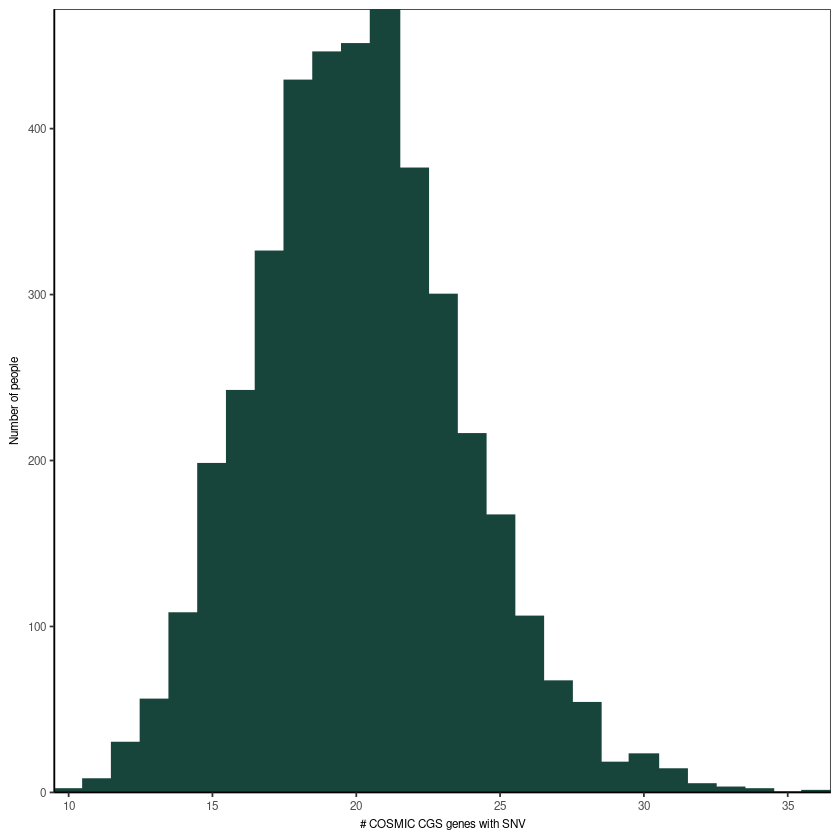

In [9]:
#Now plot the plot!
affected.genes.per.person %>%
ggplot(aes(x = num_genes)) +
geom_histogram(bins = 27, color = rgb(24, 69, 59, maxColorValue = 255), fill = rgb(24, 69, 59, maxColorValue = 255)) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of people") +
xlab("# COSMIC CGS genes with SNV")


setwd("../output")
ggsave("figure_4c.pdf", width = 5, height = 3)

In [10]:
#Also export the dataframe that went into making figure 4c
setwd("../output")
write.table(affected.genes.per.person, "figure_4c_affected_genes_per_person.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [11]:
#Get vectors for all of the samples that we want.
set.seed(42)
random.nfe.samples = sample.annotation %>% filter(ancestry %in% "nfe") %>% sample_n(25)
random.fin.samples = sample.annotation %>% filter(ancestry %in% "fin") %>% sample_n(25)
random.eas.samples = sample.annotation %>% filter(ancestry %in% "eas") %>% sample_n(25) 
random.amr.samples = sample.annotation %>% filter(ancestry %in% "amr") %>% sample_n(25)
random.sas.samples = sample.annotation %>% filter(ancestry %in% "sas") %>% sample_n(25) 
random.mid.samples = sample.annotation %>% filter(ancestry %in% "mid") %>% sample_n(25)

#bind all of the datasets together
selected.samples = rbind(random.nfe.samples, random.fin.samples, random.eas.samples, random.amr.samples, random.sas.samples, random.mid.samples)

In [12]:
#Filter the genotyping data to only include the selected samples
selected.cosmic.matrix = cosmic.tier1.matrix %>%
rename_all(~gsub("\\.", "-", .)) %>%
select(seq, all_of(selected.samples$sample)) %>%
mutate(across(-seq, ~ ifelse(. > 1, 1, .))) %>%
rename("gene" = seq)

In [13]:
#Go through all of the cell lines and get a dataframe that has which genes are affected in each cell line
affected.gene.list = selected.cosmic.matrix %>% 
melt(id = "gene") %>%
filter(value %in% "1") %>%
select(-value) %>%
rename("sample" = variable)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


In [14]:
#Get a vector of all unique samples
unique.samples = affected.gene.list %>%
pull(sample) %>%
unique() %>%
as.character()

In [19]:
#Now loop through everything and compute an intersection matrix
intersection.matrix = NULL
for(line in unique.samples){
    
    affected.gene.v1 = affected.gene.list %>% filter(sample %in% line) %>% pull(gene) %>% unique()
    
    intersection.vector = NULL
    for(i in 1:length(unique.samples)){
        
        #Extract a vector of affected genes
        second.line.of.interest = unique.samples[i]
        affected.gene.vi = affected.gene.list %>% filter(sample %in% second.line.of.interest) %>% pull(gene) %>% unique()
        
        #Calculate the intersection length
        intersection.length = intersect(affected.gene.v1, affected.gene.vi) %>% length()
        
        #Export it outside of the loop
        intersection.vector[i] = intersection.length    
    }
    
    #Now export the final vector to outside of the loop and store it as a df
    intersection.matrix = cbind(intersection.matrix, intersection.vector)
    
}

#Rename the matrix
colnames(intersection.matrix) = unique.samples
intersection.matrix = intersection.matrix %>%
data.frame() %>%
mutate("sample" = unique.samples, .before = 1)

In [20]:
#Randomly select samples
set.seed(42)
random.nfe.samples = sample.annotation %>% filter(ancestry %in% "nfe") %>% sample_n(5)
random.fin.samples = sample.annotation %>% filter(ancestry %in% "fin") %>% sample_n(5)
random.eas.samples = sample.annotation %>% filter(ancestry %in% "eas") %>% sample_n(5) 
random.amr.samples = sample.annotation %>% filter(ancestry %in% "amr") %>% sample_n(5)
random.sas.samples = sample.annotation %>% filter(ancestry %in% "sas") %>% sample_n(5) 
random.mid.samples = sample.annotation %>% filter(ancestry %in% "mid") %>% sample_n(5)
random.afr.samples = sample.annotation %>% filter(ancestry %in% "afr") %>% sample_n(5)

#bind all of the datasets together
selected.samples = rbind(random.nfe.samples, random.fin.samples, random.eas.samples, random.amr.samples, random.sas.samples, random.mid.samples, random.afr.samples)

In [26]:
#Filter the genotyping data to only include the selected samples
selected.cosmic.matrix = cosmic.tier1.matrix %>%
rename_all(~gsub("\\.", "-", .)) %>%
select(seq, all_of(selected.samples$sample)) %>%
mutate(across(-seq, ~ ifelse(. > 1, 1, .))) %>%
rename("gene" = seq) %>%
filter(gene %in% cosmic.tier1.for.heatmap)

In [27]:
#Calculate the row order
factor.order.df = selected.cosmic.matrix %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
group_by(gene) %>%
summarise("total_affected" = sum(value)) %>%
arrange(total_affected)

#Calculate the total number of affected cells per ancestry group
total.affected.cells.df = selected.cosmic.matrix %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
group_by(ancestry) %>%
summarise("total_affected_cells" = sum(value))

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


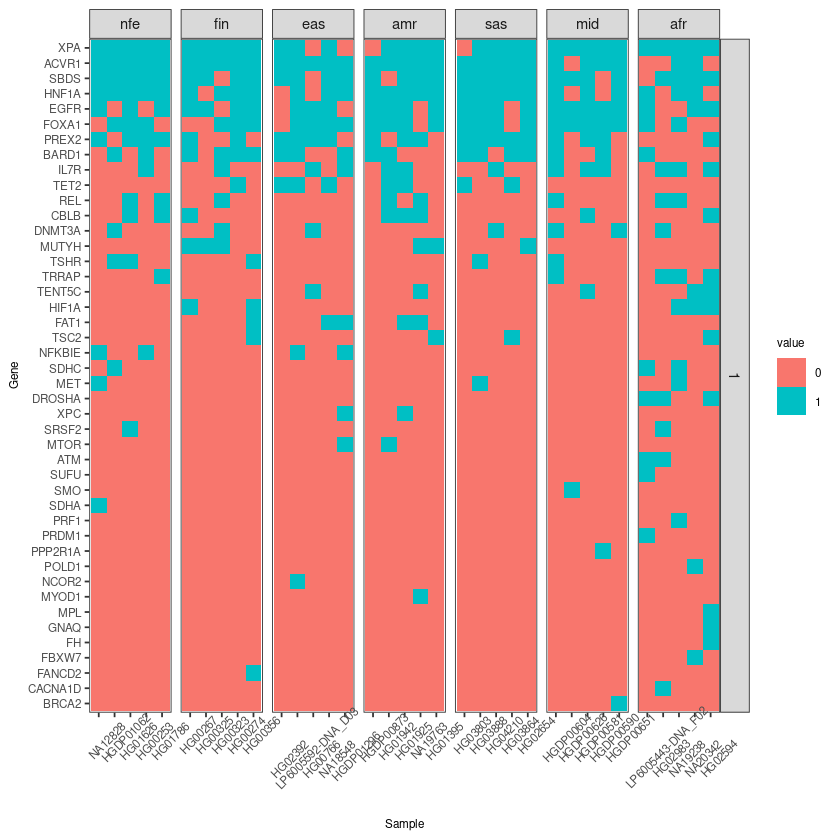

In [28]:
#Create the heatmap
selected.cosmic.matrix %>%
mutate(gene = factor(gene, levels = factor.order.df$gene)) %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
mutate(value = as.character(value)) %>%
ggplot(aes(x = sample, y = gene, fill = value)) +
geom_tile() +
facet_grid(1 ~ ancestry, scale = "free") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Gene") +
xlab("Sample") +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.25)
)


#Export it to the google bucket
setwd('../output')
ggsave("figure_4d.pdf", width = 6, height = 8)

In [29]:
#Also export the dataframe used to make the figure
fig_4d_df = selected.cosmic.matrix %>%
mutate(gene = factor(gene, levels = factor.order.df$gene)) %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
mutate(value = as.character(value))

setwd("../output")
write.table(fig_4d_df, "figure_4d_cosmix_matrix.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”
